In [38]:
from fastai.imports import *
from fastai.structured import * 
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from IPython.display import display
from sklearn.linear_model import LogisticRegression
# from collections import Counter
# from sklearn.linear_model import LogisticRegression
from statistics import *
from sklearn.model_selection import StratifiedKFold
# from sklearn import metrics
import feather
import seaborn as sns
from collections import Counter
# from sklearn.model_selection import
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score,classification_report,confusion_matrix
from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.feature_selection import RFE, f_regression
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from xgboost import plot_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

We will join the tables and extract some features to create a Final dataset

In [39]:
df_camp = pd.read_csv('D:/Kaggle/AmExpert/campaign_data.csv',parse_dates=['start_date','end_date'],low_memory=False)
df_trans = pd.read_csv('D:/Kaggle/AmExpert/customer_transaction_data.csv',parse_dates=['date'],low_memory=False)
items_table = pd.read_csv("D:/Kaggle/AmExpert/item_data.csv",low_memory=False) 
demographics_table = pd.read_csv("D:/Kaggle/AmExpert/customer_demographics.csv",low_memory=False)
coupon_map = pd.read_csv('D:/Kaggle/AmExpert/coupon_item_mapping.csv',low_memory=False) 
df_train = pd.read_csv('D:/Kaggle/AmExpert/train.csv',low_memory=False)

In [40]:
ftable = coupon_map.groupby('coupon_id').agg({'coupon_id': lambda x: len(x)})
ftable.rename(
    columns={
        'coupon_id':'coupon_used'
    },inplace=True)

In [41]:
itable = coupon_map.groupby('item_id').agg({'item_id': lambda x: len(x)})
itable.rename(
    columns={
        'item_id':'item_bought_with_coupon'
    },inplace=True)

In [42]:
df_train_fin = pd.merge(df_train,ftable,how='left',on='coupon_id')

In [43]:
df_train_fin

,id,campaign_id,coupon_id,customer_id,redemption_status,coupon_used
0,1,13,27,1053,0,125
1,2,13,116,48,0,3
2,6,9,635,205,0,67
3,7,13,644,1050,0,4
4,9,8,1017,1489,0,32
5,11,11,795,793,0,13
6,14,9,444,590,0,14
7,15,29,538,368,0,9
8,17,30,857,523,0,14
9,19,2,559,679,0,31


In [44]:
items_table = pd.merge(items_table,itable,how='left',on='item_id')

In [45]:
items_table = items_table.fillna(0)

In [46]:
df_trans_item = pd.merge(df_trans,items_table,on='item_id',how='left')

In [47]:
import datetime as dt
df_camp['camp_duration'] = df_camp['end_date'] - df_camp['start_date']
df_camp['camp_duration'].astype('timedelta64[D]')
df_camp['camp_duration']=df_camp['camp_duration'] / np.timedelta64(1, 'D')
df_camp['camp_duration'] = df_camp.camp_duration.abs()

In [48]:
ctable = df_camp.groupby('campaign_type').agg({'campaign_type': lambda x: len(x)})
ctable.rename(columns={'campaign_type':'freq_camp'},inplace=True)
df_camp = pd.merge(df_camp,ctable,how='left',on='campaign_type')
# df_camp.drop(['start_date','end_date'],axis=1,inplace=True)

In [49]:
df_trans_item.drop('item_bought_with_coupon',axis=1,inplace=True)

In [50]:
df_trans_item.head().T

,0,1,2,3,4
date,2012-01-02 00:00:00,2012-01-02 00:00:00,2012-01-02 00:00:00,2012-01-02 00:00:00,2012-01-02 00:00:00
customer_id,1501,1501,1501,1501,1501
item_id,26830,54253,31962,33647,48199
quantity,1,1,1,1,1
selling_price,35.26,53.43,106.5,67.32,71.24
other_discount,-10.69,-13.89,-14.25,0,-28.14
coupon_discount,0,0,0,0,0
brand,56,56,524,1134,524
brand_type,Local,Local,Established,Established,Established
category,Natural Products,Natural Products,Grocery,Grocery,Grocery


In [51]:
df_trans_item.category.value_counts()

Grocery                   942176
Pharmaceutical            155245
Packaged Meat              66110
Natural Products           52981
Meat                       23056
Dairy, Juices & Snacks     20465
Bakery                     18218
Fuel                       13797
Prepared Food              13069
Seafood                     7043
Skin & Hair Care            4868
Miscellaneous               3197
Flowers & Plants            1602
Alcohol                     1343
Salads                       429
Garden                       413
Travel                       247
Restauarant                  211
Vegetables (cut)              96
Name: category, dtype: int64

In [52]:
dummy = pd.get_dummies(df_trans_item['category'])
dummy_category =  pd.get_dummies(df_trans_item['category'])
dummy_brand_type = pd.get_dummies(df_trans_item['brand_type'])
dummy_brand_type =  pd.get_dummies(df_trans_item['brand_type'])

In [53]:
df_trans_item = pd.concat([df_trans_item,dummy_brand_type],axis=1)
df_trans_item = pd.concat([df_trans_item,dummy_category],axis=1)
df_trans_item.drop(['category','brand_type'],axis=1,inplace=True)

In [19]:
add_datepart(df_trans_item,'date')

In [20]:
df_trans_item.head().T

,0,1,2,3,4
customer_id,1501,1501,1501,1501,1501
item_id,26830,54253,31962,33647,48199
quantity,1,1,1,1,1
selling_price,35.26,53.43,106.5,67.32,71.24
other_discount,-10.69,-13.89,-14.25,0,-28.14
coupon_discount,0,0,0,0,0
brand,56,56,524,1134,524
Established,0,0,1,1,1
Local,1,1,0,0,0
Alcohol,0,0,0,0,0


In [21]:
df_trans_item.drop('Elapsed',axis=1,inplace=True)

In [22]:
df_trans_item['cost_price'] = df_trans_item['selling_price'] - df_trans_item['coupon_discount'] - df_trans_item['other_discount']

In [23]:
labels = ['customer_id','item_id','quantity','Local','Established',
          'Alcohol','Bakery','Pharmaceutical','Prepared Food','Restauarant',
          'Salads','Seafood','Skin & Hair Care','Travel','Vegetables (cut)','Dairy, Juices & Snacks',
          'Flowers & Plants','Fuel','Garden','Grocery','Meat','Miscellaneous','Packaged Meat','Natural Products',
          'brand','Year','Month','Week','Dayofyear','Dayofweek','Is_month_end','Is_month_start',
          'Is_quarter_end','Is_quarter_start','Is_year_end','Is_year_start','cost_price']
          

In [388]:
total_labels = []
for i in labels:
    k = 'K_'+i+'_sum'
    total_labels.append(k)


In [390]:

for i in labels:
    k = 'K_'+i+'_count'
    total_labels.append(k)

In [24]:
total_labels

NameError: name 'total_labels' is not defined

Creating all the count,sum,min,max features

In [25]:
agg_func = {
    'customer_id': ['count'],
    'item_id': ['count'],
    'selling_price': ['sum', 'mean','min','max'],
    'other_discount': ['sum', 'mean','min','max'],
    'coupon_discount': ['sum', 'mean','min','max'],
    'quantity': ['count','sum', 'mean'],
    'Local':['sum','mean','count','min','max'],
    'Established':['sum','mean','count','min','max'],
    'Alcohol': ['min','max','count','mean','sum'],
    'Bakery': ['min','max','count','mean','sum'],
    'Pharmaceutical': ['min','max','count','mean','sum'],
    'Prepared Food': ['min','max','count','mean','sum'],
    'Restauarant': ['min','max','count','mean','sum'],
    'Salads': ['min','max','count','mean','sum'],
    'Seafood': ['min','max','count','mean','sum'],
    'Skin & Hair Care': ['min','max','count','mean','sum'],
    'Travel': ['min','max','count','mean','sum'],
    'Vegetables (cut)': ['min','max','count','mean','sum'],
    'Dairy, Juices & Snacks': ['min','max','count','mean','sum'],
    'Flowers & Plants': ['min','max','count','mean','sum'],
    'Fuel': ['min','max','count','mean','sum'],
    'Garden': ['min','max','count','mean','sum'],
    'Grocery': ['min','max','count','mean','sum'],
    'Meat': ['min','max','count','mean','sum'],
    'Miscellaneous': ['min','max','count','mean','sum'],
    'Meat': ['min','max','count','mean','sum'],
    'Packaged Meat': ['min','max','count','mean','sum'],
    'Natural Products': ['min', 'max', 'count', 'mean','sum'],
    'brand': ['min', 'max', 'count', 'mean'],
    'Year': ['max', 'count','mean'],
    'Month':['max','count','mean','min'],
    'Week':['max','count','mean','min'],
    'Dayofyear':['max','count','mean','min'],
    'Dayofweek':['max','count','mean','min'],
    'Is_month_end':['max','count'],
    'Is_month_start':['max','count'],
    'Is_quarter_end':['max','count'],
    'Is_quarter_start':['max','count'],
    'Is_year_end':['max','count'],
    'Is_year_start':['max','count'],
    'cost_price':['max','min','count','sum','mean']
}

In [26]:
final_trans_table = df_trans_item.groupby('customer_id').agg(agg_func)

In [27]:
# dummy_age = pd.get_dummies(demographics_table['age_range'],prefix='age_range')
# dummy_marital = pd.get_dummies(demographics_table['marital_status'],prefix='marital_status')
# dummy_family = pd.get_dummies(demographics_table['family_size'],prefix='family_size')
# dummy_children = pd.get_dummies(demographics_table['no_of_children'],prefix='no_of_children')
# dummy_income =pd.get_dummies(demographics_table['income_bracket'],prefix='income_bracket')

In [28]:
# demographics_table.drop(['age_range','marital_status','family_size','no_of_children','income_bracket'],axis=1,inplace=True)

In [29]:
# demographics_table = pd.concat([demographics_table,dummy_age],axis=1)
# demographics_table = pd.concat([demographics_table,dummy_income],axis=1)
# demographics_table = pd.concat([demographics_table,dummy_family],axis=1)
# demographics_table = pd.concat([demographics_table,dummy_children],axis=1)
# demographics_table = pd.concat([demographics_table,dummy_marital],axis=1)

In [30]:
train_cats(demographics_table)
demographics_table.age_range = demographics_table.age_range.cat.codes
demographics_table.marital_status = demographics_table.marital_status.cat.codes
# demographics_table.campaign_type = demographics_table.campaign_type.cat.codes
demographics_table.family_size = demographics_table.family_size.cat.codes
demographics_table.no_of_children = demographics_table.no_of_children.cat.codes

In [31]:
demographics_table['income_bracket'].mean()

4.71578947368421

In [32]:
demographics_table['rented'] = demographics_table['rented'].fillna(0.0539)
demographics_table['income_bracket'] = demographics_table['income_bracket'].fillna(4.715)

In [304]:
demographics_table.isnull().sum()
# df_camp
# final_trans_table

customer_id       0
age_range         0
marital_status    0
rented            0
family_size       0
no_of_children    0
income_bracket    0
dtype: int64

In [33]:
demographics_table['age_range'][demographics_table['age_range'] < 0] = 0
demographics_table['marital_status'][demographics_table['marital_status'] < 0] = 0
demographics_table['family_size'][demographics_table['family_size'] < 0] = 0
demographics_table['no_of_children'][demographics_table['no_of_children'] < 0] = 0

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4:

In [ ]:
# dummy_camp = pd.get_dummies(df_camp['campaign_id'],prefix='campaign_id')

In [ ]:
# df_camp_fin = pd.concat([df_camp,dummy_camp],axis=1)

In [34]:
final_trans_table.columns = ['K_'+'_'.join(col).strip() for col in final_trans_table.columns.values]
final_trans_table.reset_index(inplace=True)

In [35]:
df_train_final['K_other_discount_sum'] = df_train_final['K_other_discount_sum'].abs() 

df_train_final['K_coupon_discount_sum'] = df_train_final['K_coupon_discount_sum'].abs()

NameError: name 'df_train_final' is not defined

In [385]:
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1   

In [386]:
quartiles = df_train_final.quantile(q=[0.25,0.50,0.75])
print(quartiles, type(quartiles))
quartiles=quartiles.to_dict()
quartiles

      campaign_id  coupon_id  redemption_status  coupon_used  \
0.25          8.0      280.0                0.0          5.0   
0.50         13.0      597.0                0.0         12.0   
0.75         13.0      857.0                0.0         30.0   

      K_customer_id_count  K_item_id_count  K_selling_price_sum  \
0.25                557.0            557.0             59205.59   
0.50                884.0            884.0             98840.74   
0.75               1335.0           1335.0            155596.98   

      K_selling_price_mean  K_selling_price_min  K_selling_price_max  ...  \
0.25             95.877243                 5.34               925.41  ...   
0.50            111.057371                 8.90              1286.59  ...   
0.75            130.539012                11.75              1781.00  ...   

      K_cost_price_sum  K_cost_price_mean  age_range  marital_status  rented  \
0.25          69055.79         113.840149        2.0             0.0     0.0   
0.50 

{'campaign_id': {0.25: 8.0, 0.5: 13.0, 0.75: 13.0},
 'coupon_id': {0.25: 280.0, 0.5: 597.0, 0.75: 857.0},
 'redemption_status': {0.25: 0.0, 0.5: 0.0, 0.75: 0.0},
 'coupon_used': {0.25: 5.0, 0.5: 12.0, 0.75: 30.0},
 'K_customer_id_count': {0.25: 557.0, 0.5: 884.0, 0.75: 1335.0},
 'K_item_id_count': {0.25: 557.0, 0.5: 884.0, 0.75: 1335.0},
 'K_selling_price_sum': {0.25: 59205.59000000005,
  0.5: 98840.74000000003,
  0.75: 155596.9800000002},
 'K_selling_price_mean': {0.25: 95.87724306688462,
  0.5: 111.057371048253,
  0.75: 130.53901238938016},
 'K_selling_price_min': {0.25: 5.34, 0.5: 8.9, 0.75: 11.75},
 'K_selling_price_max': {0.25: 925.41, 0.5: 1286.59, 0.75: 1781.0},
 'K_other_discount_sum': {0.25: 9294.290000000003,
  0.5: 15290.490000000003,
  0.75: 23509.230000000014},
 'K_other_discount_mean': {0.25: -20.866230859835117,
  0.5: -16.724106280193272,
  0.75: -13.89714843750003},
 'K_other_discount_min': {0.25: -493.69, 0.5: -355.84, 0.75: -231.89},
 'K_other_discount_max': {0.25: 0

In [310]:
df_train_final.head().T

,0,1,2,3,4
campaign_id,13,13,9,13,8
coupon_id,27,116,635,644,1017
coupon_used,125,3,67,4,32
K_customer_id_count,310,385,970,237,562
K_item_id_count,310,385,970,237,562
K_selling_price_sum,57120.8,90185.1,117462,23291.4,67797.5
K_selling_price_mean,184.26,234.247,121.094,98.276,120.636
K_other_discount_sum,10282.4,10664.2,17261.8,3947.37,11534.9
K_other_discount_mean,33.1689,27.6992,17.7957,16.6556,20.5247
K_other_discount_count,310,385,970,237,562


In [477]:
for i in total_labels:
    df_train_final[i+'_Quartile']=df_train_final[i].apply(FMClass, args=(i,quartiles,))

In [36]:
df_train_final = pd.merge(df_train_fin,final_trans_table,how='left',on='customer_id')
df_train_final = pd.merge(df_train_final,demographics_table,how='left',on='customer_id')
df_train_final = pd.merge(df_train_final,df_camp,how='left',on='campaign_id')

,id,campaign_id,coupon_id,customer_id,redemption_status,coupon_used,K_customer_id_count,K_item_id_count,K_selling_price_sum,K_selling_price_mean,...,marital_status,rented,family_size,no_of_children,income_bracket,campaign_type,start_date,end_date,camp_duration,freq_camp
0,1,13,27,1053,0,125,310,310,57120.75,184.260484,...,0.0,0.0,0.0,0.0,5.0,X,2013-05-19,2013-05-07,12.0,6
1,2,13,116,48,0,3,385,385,90185.10,234.247013,...,0.0,0.0,1.0,0.0,3.0,X,2013-05-19,2013-05-07,12.0,6
2,6,9,635,205,0,67,970,970,117461.66,121.094495,...,0.0,0.0,1.0,0.0,7.0,Y,2013-11-03,2013-12-04,31.0,22
3,7,13,644,1050,0,4,237,237,23291.42,98.276034,...,NaN,NaN,NaN,NaN,NaN,X,2013-05-19,2013-05-07,12.0,6
4,9,8,1017,1489,0,32,562,562,67797.49,120.636103,...,0.0,0.0,1.0,0.0,3.0,X,2013-02-16,2013-05-04,77.0,6
5,11,11,795,793,0,13,1720,1720,254460.17,147.941959,...,0.0,0.0,1.0,0.0,5.0,Y,2013-04-22,2013-07-06,75.0,22
6,14,9,444,590,0,14,1284,1284,180245.30,140.377960,...,0.0,0.0,1.0,0.0,1.0,Y,2013-11-03,2013-12-04,31.0,22
7,15,29,538,368,0,9,2534,2534,266723.64,105.257948,...,0.0,0.0,0.0,0.0,5.0,Y,2012-08-10,2012-11-30,112.0,22
8,17,30,857,523,0,14,243,243,30478.17,125.424568,...,NaN,NaN,NaN,NaN,NaN,X,2012-11-19,2013-04-01,133.0,6
9,19,2,559,679,0,31,1368,1368,157174.90,114.893933,...,1.0,1.0,1.0,0.0,4.0,Y,2012-12-17,2013-01-18,32.0,22


In [469]:
df_train_final.drop(['id','customer_id'],axis=1,inplace=True)

In [470]:
train_cats(df_train_final)

In [471]:
df_train_final.campaign_type = df_train_final.campaign_type.cat.codes

In [472]:
df_train_final.fillna(0,inplace=True)

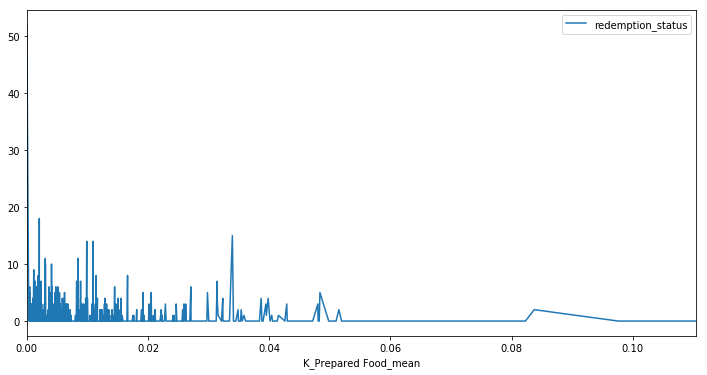

In [473]:
df_train_final.groupby('K_Prepared Food_mean').agg({'redemption_status':'sum'}).plot(figsize=(12,6))

In [474]:
y = df_train_final['redemption_status']

In [475]:
df_train_final.drop(['redemption_status'],axis=1,inplace=True)

In [476]:
df_train_final.head().T

,0,1,2,3,4
campaign_id,13,13,9,13,8
coupon_id,27,116,635,644,1017
coupon_used,125,3,67,4,32
K_customer_id_count,310,385,970,237,562
K_item_id_count,310,385,970,237,562
K_selling_price_sum,57120.8,90185.1,117462,23291.4,67797.5
K_selling_price_mean,184.26,234.247,121.094,98.276,120.636
K_selling_price_min,17.45,7.12,17.45,13.89,8.9
K_selling_price_max,5164.54,1758.92,1056.13,708.48,1424.8
K_other_discount_sum,-10282.4,-10664.2,-17261.8,-3947.37,-11534.9


In [400]:
from sklearn.feature_selection import RFE

rfe = RFE(RandomForestClassifier(n_jobs=-1, random_state=1))

rfe.fit(df_train_final,y)

print('Selected features:')
print(rfe.support_)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change 

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change 

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change 

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change 

Selected features:
[ True  True  True  True  True  True  True  True  True  True  True  True False  True  True  True False  True
  True  True  True  True  True False False  True  True  True False False False False  True  True False False
 False  True  True  True False False  True  True  True False False  True  True  True False False  True False
 False False False  True  True False False False  True  True  True False False  True  True  True False False
  True False  True False False  True False False False False  True  True  True False False  True  True  True
 False False  True  True  True False False  True  True False False False  True  True  True False False  True
  True  True False False  True  True  True False False  True  True  True False False  True  True  True False
  True  True  True False  True  True False  True  True False  True  True  True False  True  True  True  True
 False  True  True False False  True  True  True False  True False  True False  True False  True  True  True


Using RFE to select best features but it doesnt necesaarily mean that RFE gives the best features it might also remove some features that arent important

In [401]:
labels = df_train_final.columns


In [402]:
labels_rfe = labels[rfe.support_].to_list()

In [403]:
pickle_out = open("labels_rfr_final.pickle","wb")
pickle.dump(labels_rfe, pickle_out)
pickle_out.close()

In [404]:
len(labels_rfe)

118

In [467]:
df_train_final[labels_rfe]

,campaign_id,coupon_id,coupon_used,K_customer_id_count,K_item_id_count,K_selling_price_sum,K_selling_price_mean,K_selling_price_min,K_selling_price_max,K_other_discount_sum,...,K_coupon_discount_sum_Quartile,K_quantity_sum_Quartile,K_Local_sum_Quartile,K_Pharmaceutical_sum_Quartile,K_Prepared Food_sum_Quartile,K_Seafood_sum_Quartile,K_Skin & Hair Care_sum_Quartile,"K_Dairy, Juices & Snacks_sum_Quartile",K_Meat_sum_Quartile,K_Natural Products_sum_Quartile
0,13,27,125,310,310,57120.75,184.260484,17.45,5164.54,10282.37,...,3,2,3,4,4,2,4,4,2,4
1,13,116,3,385,385,90185.10,234.247013,7.12,1758.92,10664.18,...,1,3,4,3,3,2,4,4,3,3
2,9,635,67,970,970,117461.66,121.094495,17.45,1056.13,17261.79,...,1,4,3,3,1,4,2,2,1,2
3,13,644,4,237,237,23291.42,98.276034,13.89,708.48,3947.37,...,3,4,4,4,3,4,3,4,4,4
4,8,1017,32,562,562,67797.49,120.636103,8.90,1424.80,11534.90,...,2,2,3,4,4,4,4,4,3,4
5,11,795,13,1720,1720,254460.17,147.941959,10.69,2181.72,32397.91,...,1,2,2,1,4,2,2,4,1,4
6,9,444,14,1284,1284,180245.30,140.377960,8.90,2148.24,23471.15,...,3,1,2,2,1,4,1,1,2,1
7,29,538,9,2534,2534,266723.64,105.257948,8.90,1637.81,34784.97,...,3,1,1,1,1,1,1,1,1,1
8,30,857,14,243,243,30478.17,125.424568,14.25,652.56,4445.01,...,2,4,4,4,4,1,4,4,4,4
9,2,559,31,1368,1368,157174.90,114.893933,9.97,1626.77,22744.22,...,4,3,3,2,1,1,4,4,2,2


In [483]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train_final[labels_rfe],y, test_size=0.05, random_state=42)

In [484]:
len(X_valid)

3919

Using DATA Extrapolation to select and delete features that cause the overfitting and cause problems in predictive power of the algorithm

In [511]:
n_trn = len(X_train) - len(X_valid)

In [512]:
df_ext = X_train.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [521]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(temp, y);
m.oob_score_

0.9473606447280054

In [526]:
feats = ['coupon_id','coupon_used','campaign_id','camp_duration','freq_camp','campaign_type','K_Dayofweek_mean','K_Year_mean','K_selling_price_max']

In [89]:
(X_train[feats]/1000).describe()

,coupon_id,coupon_used
count,62695.000000,62695.000000
mean,0.566567,0.082379
std,0.329744,0.609689
min,0.001000,0.001000
25%,0.280000,0.005000
50%,0.597000,0.012000
75%,0.855000,0.030000
max,1.115000,11.813000


In [90]:
(X_valid[feats]/1000).describe()

,coupon_id,coupon_used
count,15674.000000,15674.000000
mean,0.565549,0.080128
std,0.330861,0.586053
min,0.001000,0.001000
25%,0.278000,0.005000
50%,0.597000,0.012000
75%,0.861500,0.030000
max,1.115000,11.813000


In [517]:
x[to_keep]

,coupon_used,coupon_id,camp_duration,campaign_id,K_coupon_discount_sum,K_coupon_discount_mean,campaign_type,freq_camp,K_coupon_discount_min,K_Year_mean,...,K_Grocery_mean,K_Dayofyear_max,K_selling_price_sum,"K_Dairy, Juices & Snacks_sum",K_Miscellaneous_mean,"K_Dairy, Juices & Snacks_mean",K_Packaged Meat_sum,K_Meat_sum,K_selling_price_max,K_Pharmaceutical_sum
5994,6,341,133.0,30,-1431.89,-0.811269,0,6,-71.24,2012.414731,...,0.731445,364,205834.89,2.0,0.001700,0.001133,39,15,1959.10,268.0
67554,1,1057,78.0,26,-480.87,-0.567064,0,6,-89.05,2012.341981,...,0.737028,366,93290.45,8.0,0.000000,0.009434,63,39,1276.62,64.0
21537,16,421,133.0,30,-267.17,-0.191520,0,6,-35.62,2012.296057,...,0.778495,363,92774.75,4.0,0.000000,0.002867,144,51,612.66,35.0
66614,9,1058,77.0,8,-1241.00,-1.187560,0,6,-142.48,2012.486124,...,0.844976,363,134718.73,4.0,0.013397,0.003828,79,7,7480.20,29.0
66671,16,410,78.0,26,0.00,0.000000,0,6,0.00,2012.372624,...,0.701521,355,55009.06,2.0,0.000000,0.003802,15,1,1424.44,74.0
50269,65,660,78.0,26,-458.78,-0.389126,0,6,-89.05,2012.306192,...,0.789652,362,131756.75,1.0,0.000000,0.000848,18,21,2172.82,152.0
74581,87,91,77.0,8,-10.69,-0.016003,0,6,-10.69,2012.482036,...,0.648204,365,89772.97,12.0,0.000000,0.017964,31,13,3165.91,108.0
44513,4,737,77.0,8,-5123.17,-3.828976,0,6,-120.75,2012.388640,...,0.763827,366,165138.17,29.0,0.000747,0.021674,54,6,1882.87,69.0
2731,6,828,56.0,3,-1194.24,-0.695539,1,22,-102.59,2012.359930,...,0.719860,366,187362.68,6.0,0.001165,0.003494,54,10,988.46,193.0
58289,5,653,12.0,13,-174.54,-0.080545,0,6,-35.62,2012.421320,...,0.634056,366,289274.01,21.0,0.000000,0.009691,164,33,2065.96,409.0


In [91]:
(df_test_final[feats]/1000).describe()

,coupon_id,coupon_used
count,50226.000000,50226.000000
mean,0.589657,0.107948
std,0.312243,0.711479
min,0.028000,0.001000
25%,0.266000,0.007000
50%,0.592000,0.016000
75%,0.864000,0.039000
max,1.116000,11.814000


In [508]:
x.drop(feats, axis=1, inplace=True)

In [519]:
temp = x[to_keep]

In [520]:
temp.drop(feats,axis=1,inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [522]:
fi = rf_feat_importance(m, temp); fi[:10]

,cols,imp
3,freq_camp,0.084857
2,campaign_type,0.083237
6,K_Dayofweek_mean,0.037283
5,K_Year_mean,0.037046
30,K_selling_price_max,0.035072
8,K_Prepared Food_mean,0.033275
12,K_Packaged Meat_mean,0.033029
18,K_quantity_mean,0.032908
21,K_Natural Products_mean,0.032695
17,K_Meat_mean,0.030939


In [499]:
to_keep = fi[fi.imp>0.006].cols; len(to_keep)

36

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

Here we come to know the feature freq_camp causes all sorts of problems , using feature Importance and extrapolation we remove this and then we reduce overfitting this feature was highly collinear to another feature causing the overfitting

In [480]:
X_train.drop('freq_camp',axis=1,inplace=True)
X_valid.drop('freq_camp',axis=1,inplace=True)

In [534]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True,random_state=17)
m.fit(X_train_f, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=17, verbose=0,
                       warm_start=False)

In [535]:
y_preds_valid = m.predict_proba(X_valid_f)[:,1]
print(roc_auc_score(y_valid,y_preds_valid))

0.9547655781263392


In [523]:
X_train = X_train[to_keep]
X_valid = X_valid[to_keep]

In [536]:
X_train.drop('freq_camp',axis=1,inplace=True)
X_valid.drop('freq_camp',axis=1,inplace=True)

In [103]:
def print_score(m):
    res=[]
    y_preds_train = m.predict_proba(X_train)[:,1]
    print(roc_auc_score(y_preds_train,y_train))
    y_preds_valid = m.predict_proba(X_valid)[:,1]
    print(roc_auc_score(y_preds_valid, y_valid))
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [527]:
for f in feats:
    print(f)
    X_train_f = X_train.drop(f, axis=1)
    X_valid_f = X_valid.drop(f,axis=1)
    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True,random_state=17)
    m.fit(X_train_f, y_train)
    y_preds_train = m.predict_proba(X_train_f)[:,1]
    print(roc_auc_score(y_train,y_preds_train))
    y_preds_valid = m.predict_proba(X_valid_f)[:,1]
    print(roc_auc_score(y_valid,y_preds_valid))

coupon_id
0.9970350005583689
0.8963401045684409
coupon_used
0.9972809272448653
0.9281606239821719
campaign_id
0.9988801587307591
0.8786277534927576
camp_duration
0.9988199864179722
0.8815805262706781
freq_camp
0.9988383077427392
0.9547655781263392
campaign_type
0.9988382883448305
0.9547612925344989
K_Dayofweek_mean
0.9988235265363099
0.9208794034456158
K_Year_mean
0.9987803952863159
0.9264635296134397
K_selling_price_max
0.9987666712659108
0.9261549670009429


In [533]:
X_train_f = X_train.drop(['freq_camp'],axis=1)
X_valid_f = X_valid.drop(['freq_camp'],axis=1)

In [113]:
X_train_f

,campaign_id,coupon_id,coupon_used,K_customer_id_count,K_selling_price_sum,K_selling_price_mean,K_other_discount_sum,K_other_discount_mean,K_other_discount_count,K_coupon_discount_sum,...,K_Is_month_end_count,K_Is_month_start_count,K_Is_quarter_end_count,K_Is_year_start_count,age_range,family_size,income_bracket,campaign_type,camp_duration,freq_camp
33752,8,727,61,893,109615.33,122.749530,-14969.09,-16.762699,893,-17.81,...,893,893,893,893,4.0,0.0,9.0,0,77.0,6
59685,13,172,24,862,88813.57,103.031984,-14856.54,-17.234965,862,-4291.84,...,862,862,862,862,0.0,0.0,0.0,0,12.0,6
55005,13,692,65,970,112154.17,115.622856,-16863.49,-17.385041,970,-19.59,...,970,970,970,970,1.0,1.0,1.0,0,12.0,6
37692,8,1015,14,3328,274081.02,82.356076,-47981.49,-14.417515,3328,-2120.10,...,3328,3328,3328,3328,0.0,0.0,0.0,0,77.0,6
58490,8,76,1,1203,185016.35,153.795802,-19222.28,-15.978620,1203,0.00,...,1203,1203,1203,1203,2.0,1.0,3.0,0,77.0,6
71959,8,554,9,811,79617.74,98.172306,-26783.71,-33.025536,811,-4834.25,...,811,811,811,811,0.0,0.0,0.0,0,77.0,6
20825,13,1100,5,898,99880.96,111.226013,-22175.27,-24.694065,898,-187.00,...,898,898,898,898,4.0,0.0,4.0,0,12.0,6
51892,13,667,19,792,72398.46,91.412197,-10138.99,-12.801755,792,0.00,...,792,792,792,792,1.0,1.0,2.0,0,12.0,6
4364,8,817,16,519,60377.65,116.334586,-5388.51,-10.382486,519,-35.62,...,519,519,519,519,0.0,0.0,0.0,0,77.0,6
25142,11,1044,9,1598,224598.09,140.549493,-22241.88,-13.918573,1598,-149.60,...,1598,1598,1598,1598,2.0,4.0,6.0,1,75.0,22


In [125]:
X_train[labels[140:180]].isnull().sum()

K_Dayofweek_count           0
K_Dayofweek_mean            0
K_Dayofweek_min             0
K_Is_month_end_max          0
K_Is_month_end_count        0
K_Is_month_start_max        0
K_Is_month_start_count      0
K_Is_quarter_end_max        0
K_Is_quarter_end_count      0
K_Is_quarter_start_max      0
K_Is_quarter_start_count    0
K_Is_year_end_max           0
K_Is_year_end_count         0
K_Is_year_start_max         0
K_Is_year_start_count       0
rented                      0
age_range_18-25             0
age_range_26-35             0
age_range_36-45             0
age_range_46-55             0
age_range_56-70             0
age_range_70+               0
income_bracket_1            0
income_bracket_2            0
income_bracket_3            0
income_bracket_4            0
income_bracket_5            0
income_bracket_6            0
income_bracket_7            0
income_bracket_8            0
income_bracket_9            0
income_bracket_10           0
income_bracket_11           0
income_bra

In [47]:
labels = X_train.columns

In [45]:
from sklearn.feature_selection import RFE

rfe = RFE(RandomForestClassifier(n_jobs=-1, random_state=1))

# rfe.fit(X_train,y_train)

print('Selected features:')
print(rfe.support_)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change 

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change 

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change 

Selected features:
[ True  True  True  True False  True  True  True  True  True  True  True  True  True  True  True  True  True
  True False False  True  True  True False False False False  True  True False False False  True  True  True
 False False  True  True  True False False  True  True  True False False  True False False False False  True
 False False False False  True  True  True False False  True  True  True False False  True False False False
 False False False False False False  True  True  True False False  True  True  True False False  True  True
  True False False  True  True  True False False  True  True  True False False  True  True  True False False
  True  True  True False False  True  True  True False False  True  True False  True  True  True False  True
  True False  True  True False  True  True  True False  True  True  True  True False  True  True False False
  True False  True False  True False  True False  True False  True False False False False False False False


In [240]:

from catboost import *

In [49]:
len(labels_rfe)

94

In [37]:
X_train.drop(['redemption_status'],axis=1,inplace=True)
X_valid.drop(['redemption_status'],axis=1,inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
df_train_final.groupby('coupon_id').agg({'redemption_status':'sum'}).plot(figsize=(12,6))

In [425]:
X_train.drop(['campaign_id','freq_camp'],axis=1,inplace=True)

In [537]:
X_train

,coupon_used,coupon_id,camp_duration,campaign_id,K_coupon_discount_sum,K_coupon_discount_mean,campaign_type,K_coupon_discount_min,K_Year_mean,K_Dayofweek_mean,...,K_Grocery_mean,K_Dayofyear_max,K_selling_price_sum,"K_Dairy, Juices & Snacks_sum",K_Miscellaneous_mean,"K_Dairy, Juices & Snacks_mean",K_Packaged Meat_sum,K_Meat_sum,K_selling_price_max,K_Pharmaceutical_sum
5994,6,341,133.0,30,-1431.89,-0.811269,0,-71.24,2012.414731,2.668555,...,0.731445,364,205834.89,2.0,0.001700,0.001133,39,15,1959.10,268.0
67554,1,1057,78.0,26,-480.87,-0.567064,0,-89.05,2012.341981,3.004717,...,0.737028,366,93290.45,8.0,0.000000,0.009434,63,39,1276.62,64.0
21537,16,421,133.0,30,-267.17,-0.191520,0,-35.62,2012.296057,3.186380,...,0.778495,363,92774.75,4.0,0.000000,0.002867,144,51,612.66,35.0
66614,9,1058,77.0,8,-1241.00,-1.187560,0,-142.48,2012.486124,3.513876,...,0.844976,363,134718.73,4.0,0.013397,0.003828,79,7,7480.20,29.0
66671,16,410,78.0,26,0.00,0.000000,0,0.00,2012.372624,3.095057,...,0.701521,355,55009.06,2.0,0.000000,0.003802,15,1,1424.44,74.0
50269,65,660,78.0,26,-458.78,-0.389126,0,-89.05,2012.306192,3.529262,...,0.789652,362,131756.75,1.0,0.000000,0.000848,18,21,2172.82,152.0
74581,87,91,77.0,8,-10.69,-0.016003,0,-10.69,2012.482036,2.486527,...,0.648204,365,89772.97,12.0,0.000000,0.017964,31,13,3165.91,108.0
44513,4,737,77.0,8,-5123.17,-3.828976,0,-120.75,2012.388640,3.832586,...,0.763827,366,165138.17,29.0,0.000747,0.021674,54,6,1882.87,69.0
2731,6,828,56.0,3,-1194.24,-0.695539,1,-102.59,2012.359930,3.326150,...,0.719860,366,187362.68,6.0,0.001165,0.003494,54,10,988.46,193.0
58289,5,653,12.0,13,-174.54,-0.080545,0,-35.62,2012.421320,3.522381,...,0.634056,366,289274.01,21.0,0.000000,0.009691,164,33,2065.96,409.0


In [585]:
gkf = list(GroupKFold(n_splits=5).split(X_train,y_train,groups))

In [602]:
# params={
#     'n_estimators':[240,300,340,380]
#     }

# m.fit(X_train[data],y_train)
# m = CatBoostClassifier(iterations=100,loss_function='Logloss',learning_rate=0.03,depth=8,random_seed=22)
# m.fit(X_train[labels_vif],y_train)
gsearch1 = GridSearchCV(estimator=m,param_grid=params,n_jobs=-1,iid=False,cv=gkf,scoring='roc_auc')
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=[(array([    0,     1,     2, ..., 74444, 74447, 74449]),
                  array([    9,    10,    11, ..., 74445, 74446, 74448])),
                 (array([    0,     1,     2, ..., 74446, 74448, 74449]),
                  array([    3,     6,     7, ..., 74427, 74436, 74447])),
                 (array([    1,     3,     4, ..., 74447, 74448, 74449]),
                  array([    0,     2,    15, ..., 74437, 74439, 74444])),
                 (array([    0,     2,     3, ..., 74446, 74447, 74448]),
                  array([    1,     4,     5, ..., 74435, 74441, 74449])),
                 (array([    0,     1,     2, ..., 74447, 74...
                                     max_delta_step=0, max_depth=4,
                                     min_child_weight=9, missing=None,
                                     n_estimators=80, n_jobs=1, nthread=-1,
                                     objective='binary:logistic',
                                     random_state=0, reg_al

In [564]:
# #modelstart= time.time()
# cb_model = CatBoostClassifier(iterations=1000,
#                              learning_rate=0.03,
#                              depth=8,
#                              eval_metric='AUC',
#                              random_seed = 23,)
# cb_model.fit(X_train, y_train,
#              eval_set=(X_valid,y_valid),
#              use_best_model=True,
#              verbose=True)

In [603]:
gsearch1.best_params_,gsearch1.best_score_

({'n_estimators': 240}, 0.8978632882332416)

In [54]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr ,mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = m.predict_proba(X_train.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [578]:
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1997)
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=5)
groups =  X_train['campaign_id']

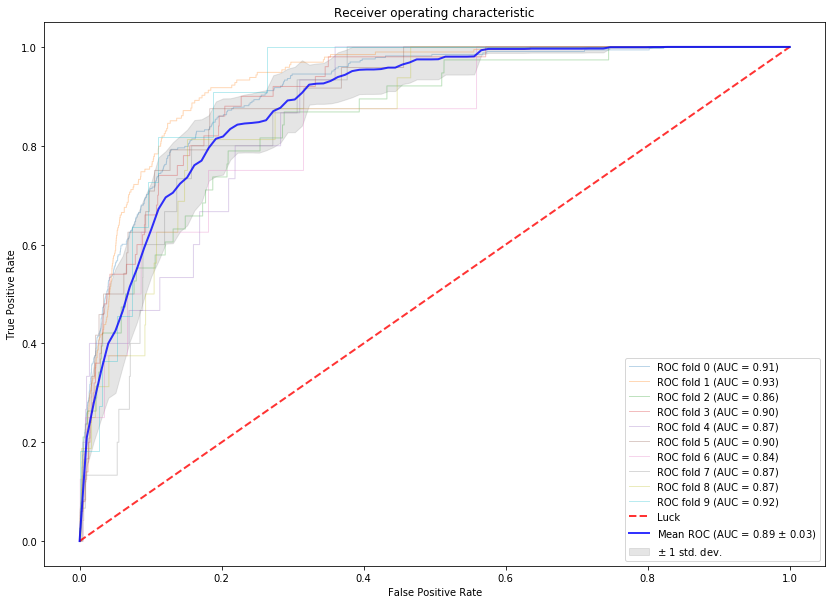

,AUC Train,AUC Test
0,0.969638,0.910985
1,0.967540,0.928910
2,0.967639,0.856959
3,0.965281,0.904403
4,0.966718,0.870731
5,0.965793,0.903280
6,0.964389,0.843213
7,0.964579,0.873831
8,0.965981,0.867884
9,0.965236,0.916365


In [607]:
cv = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
score_avg = []
for (train, test), i in zip(group_kfold.split(X_train, y_train,groups), range(10)):
    m = XGBClassifier(n_estimators=120,learning_rate=0.1,gamma=0,scale_pos_weight=1,reg_alpha=1e-5,seed=27,max_depth=4,
                  min_child_weight=9,subsample=1,nthread=-1,colsample_bytree=0.7)
    m.fit(X_train.iloc[train], y_train.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
plot_roc_curve(fprs, tprs); 
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [76]:
X_valid.drop('coupon_id',axis=1,inplace=True)

0.9349704294163024


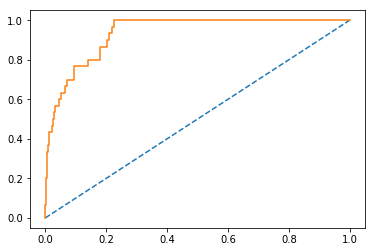

In [608]:
y_preds = m.predict_proba(X_valid)[:,1]
# print(roc_auc_score(y_valid,y_preds))
print(roc_auc_score(y_valid,y_preds))
fpr, tpr, thresholds = roc_curve(y_valid, y_preds)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr)
# show the plot
pyplot.show()

In [65]:
X_train

,campaign_id,coupon_id,coupon_used,K_customer_id_count,K_selling_price_sum,K_selling_price_mean,K_other_discount_sum,K_other_discount_mean,K_other_discount_count,K_coupon_discount_sum,...,K_Is_month_start_count,K_Is_quarter_end_count,K_Is_year_start_count,age_range,family_size,income_bracket,campaign_type,camp_duration,camp_duration_month,freq_camp
33752,8,727,61,893,109615.33,122.749530,-14969.09,-16.762699,893,-17.81,...,893,893,893,4.0,0.0,9.0,0,77.0,2.529826,6
59685,13,172,24,862,88813.57,103.031984,-14856.54,-17.234965,862,-4291.84,...,862,862,862,0.0,0.0,0.0,0,12.0,0.394259,6
55005,13,692,65,970,112154.17,115.622856,-16863.49,-17.385041,970,-19.59,...,970,970,970,1.0,1.0,1.0,0,12.0,0.394259,6
37692,8,1015,14,3328,274081.02,82.356076,-47981.49,-14.417515,3328,-2120.10,...,3328,3328,3328,0.0,0.0,0.0,0,77.0,2.529826,6
58490,8,76,1,1203,185016.35,153.795802,-19222.28,-15.978620,1203,0.00,...,1203,1203,1203,2.0,1.0,3.0,0,77.0,2.529826,6
71959,8,554,9,811,79617.74,98.172306,-26783.71,-33.025536,811,-4834.25,...,811,811,811,0.0,0.0,0.0,0,77.0,2.529826,6
20825,13,1100,5,898,99880.96,111.226013,-22175.27,-24.694065,898,-187.00,...,898,898,898,4.0,0.0,4.0,0,12.0,0.394259,6
51892,13,667,19,792,72398.46,91.412197,-10138.99,-12.801755,792,0.00,...,792,792,792,1.0,1.0,2.0,0,12.0,0.394259,6
4364,8,817,16,519,60377.65,116.334586,-5388.51,-10.382486,519,-35.62,...,519,519,519,0.0,0.0,0.0,0,77.0,2.529826,6
25142,11,1044,9,1598,224598.09,140.549493,-22241.88,-13.918573,1598,-149.60,...,1598,1598,1598,2.0,4.0,6.0,1,75.0,2.464116,22


In [449]:
df_test = pd.read_csv('D:/Kaggle/AmExpert/test.csv',low_memory=False)
df_test_fin = pd.merge(df_test,ftable,how='left',on='coupon_id')
df_test_final = pd.merge(df_test_fin,final_trans_table,how='left',on='customer_id')
df_test_final = pd.merge(df_test_final,demographics_table,how='left',on='customer_id')
df_test_final = pd.merge(df_test_final,df_camp,how='left',on='campaign_id')

In [450]:
demographics_table

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,5,0,0,1,0,4
1,6,3,0,0,1,0,5
2,7,1,0,0,2,0,3
3,8,1,0,0,3,1,6
4,10,3,1,0,0,0,5
5,11,5,1,0,1,0,1
6,12,3,0,0,1,0,7
7,13,2,1,0,0,0,2
8,14,1,0,1,1,0,6
9,15,3,0,0,1,0,6


In [451]:
train_cats(df_test_final)
df_test_final.campaign_type = df_test_final.campaign_type.cat.codes

In [452]:
df_test_final.fillna(0,inplace=True)

In [453]:
for i in total_labels:
    df_test_final[i+'_Quartile']=df_test_final[i].apply(FMClass, args=(i,quartiles,))

In [454]:
y_id = df_test_final['id']

In [455]:
df_test_final.drop(['id','customer_id'],axis=1,inplace=True)

In [457]:
df_temp.drop(['campaign_id','freq_camp'],axis=1,inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [546]:
df_temp = df_test_final[labels_rfe]

In [547]:
df_temp = df_temp[to_keep]

In [548]:
df_temp.drop('freq_camp',axis=1,inplace=True)

In [609]:
y_test_preds = m.predict_proba(df_temp)[:,1]
data = {
    'id':y_id,
    'redemption_status':y_test_preds
}
final_df = pd.DataFrame(data)
final_df.to_csv("D:/Kaggle/firstAM.csv",index=False)

Using SHAP plots with Catboost to see what features are performing well on the validation set this i came to know that there might be data leakage in the test file
and there was the test file was highly dependent on when the user renewed his coupon during a campagin now, i didnt use this feature
but this was the magic feature that improved scores by 5 to 6% 

In [248]:
import shap
from time import time
shap_values = m.get_feature_importance(Pool(X_valid ,label=y_valid), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_valid.iloc[3,:])

Exception: Length of features is not equal to the length of shap_values!

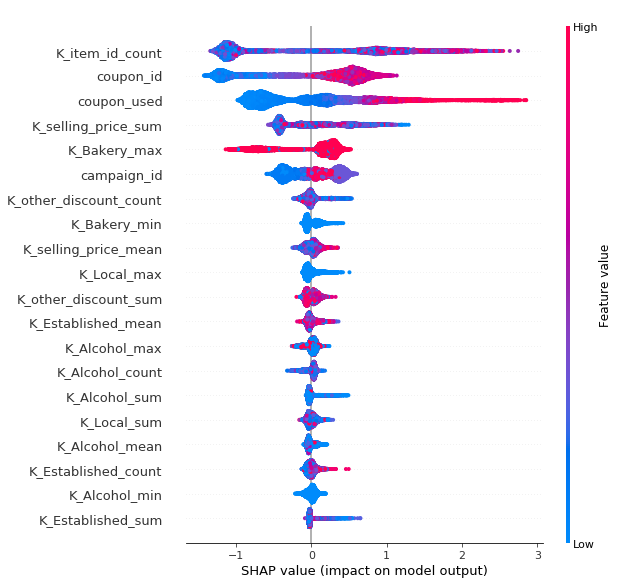

In [249]:
import time
start_time = time.time()
shap_values = m.get_feature_importance(Pool(X_valid, label=y_valid), 
                                                                     type="ShapValues")
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, X_valid) 
elapsed = time.time() - start_time

Here we see different Feature Importances methods and the best ones have to be Permutation and shap as they use the prediction on validdation set

In [ ]:
def get_feature_imp_plot(method):
    
    if method == "Permutation":
        fi =  permutation_importances(model, X_test, y_test, log_loss)
    
    elif method == "Baseline":
        fi = baseline_importance(model, X_train, y_train, X_test, y_test, log_loss)
    
    elif method == "ShapeValues":
        shap_values = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
        shap_values = shap_values[:,:-1]
        shap.summary_plot(shap_values, X_test) 
        
    else:
        fi = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

In [ ]:
%time get_feature_imp_plot(method="PredictionValuesChange")

This Competition was very interesting as there was dataleakage and one Feature could have got me to top 1% but i couldnt figure out the feature in time, but did figure out where the dataleakage and how it was happening i did little EDA not in the notebook like the Coupon usage patterns etc.But i didnt overfit at all.
Public LeaderBoard 240
Private LeaderBoard 240
TOP 10% Rank